In [214]:
from IPython.display import display, Math, Latex
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates 

### Those chunks are written for easier calculation with data analysis, especially stock-related ones
### Most of the functions are ment to apply to dataframe objects，please check the required data type when calling them
### Author: CatBot:3

In [227]:
def Merge (loDF):
    """  
    Merge a list of DataFrames together by their common index.  
    
    Parameters:  
    loDF (list): A list containing at least two DataFrames to be merged.  

    Returns:  
    pd.DataFrame: A single DataFrame resulting from merging all DataFrames in loDF.  
    
    Requirements:  
    loDF should contain at least 2 DataFrames.  
    """  
    length = len(loDF)
    if length==2:
        return pd.merge(loDF[0], loDF[1], left_index=True,right_index=True)
    elif length%2==0:
        return Merge([Merge(loDF[0:2]),Merge(loDF[2:])])
    else:
        return Merge([loDF[0],Merge(loDF[1:])])

def MA (df,n):
    """  
    Calculate the moving average (MA) of a DataFrame.  

    Parameters:  
    df (pd.DataFrame): The input DataFrame containing time series data.  
    n (int): The window size for calculating the moving average.  

    Returns:  
    pd.DataFrame: A DataFrame containing the calculated moving averages.  
    """  
    if len(df)<n:
        print('Insufficient Data')
    else:
        ma_df = df.rolling(window=n).mean()
        ma_df.columns = ma_df.columns+'_MA'+str(n)
        for i in range(0,n-1):
            ma_df.iloc[i,:]=df.iloc[0:i+1,:].mean()
        return ma_df
    
def WMA (df, n, weight_increment=1):
    """  
    Calculate the Weighted Moving Average (WMA) of a DataFrame.  
    
    Parameters:  
    df (pd.DataFrame): The input DataFrame containing numeric data.  
    n (int): The number of periods over which to calculate the WMA.  
    weight_increment (int): The incremental value for calculating weights (default is 1).  

    Returns:  
    pd.DataFrame: A DataFrame containing the calculated WMA values.  
    """  
    if len(df)<n:
        print('Insufficient Data')
    else:
        weight = [1]*n
        for i in range(1,n):
            weight[i]=weight[i-1]+weight_increment
        weight=pd.array(weight)
        total_weight = np.sum(weight)
        wma_df = df.rolling(window=n).apply(lambda array: np.sum(weight*array)/total_weight)
        wma_df.columns = wma_df.columns+'_WMA'+str(n)
        return wma_df

def SMA (df,n,m=1): #must input dataframe with a single column
    """  
    Calculate the Simple Moving Average (SMA) for a DataFrame with a single column.  
    
    Parameters:  
    df (pd.DataFrame): The input DataFrame containing one column of numeric data.  
    n (int): The number of periods over which to calculate the SMA.  
    m (int): A factor used to adjust the calculation (default is 1).  

    Returns:  
    pd.DataFrame: A DataFrame containing the calculated SMA values.  

    Requirements:
    df should only contain a single column
    """  
    sma_df = df.copy()
    sma_df.columns = df.columns+'_SMA'+str(n)
    for i in range (1,n):
        sma_df.iloc[i,0] = np.round((m*df.iloc[i,0]+(i+1-m)*sma_df.iloc[i-1,0])/(i+1),4)
    for i in range (n,len(df)):
        sma_df.iloc[i,0] = np.round((m*df.iloc[i,0]+(n-m)*sma_df.iloc[i-1,0])/n,4)
    return sma_df

def EMA (df,n): #must input dataframe with a single column
    """  
    Calculate the Exponential Moving Average (EMA) for a DataFrame with a single column.  
    
    Parameters:  
    df (pd.DataFrame): The input DataFrame containing one column of numeric data.  
    n (int): The number of periods over which to calculate the EMA.  

    Returns:  
    pd.DataFrame: A DataFrame containing the calculated EMA values.  
    
    Requirements:
    df should only contain a single column 
    """  
    ema = SMA (df, n+1, 2)
    ema.columns = [df.columns[0]+'_EMA'+str(n)]
    return ema

In [248]:
def Volume_check (df):
    """  
    Check if the last volume in the DataFrame is outside the calculated bounds.  
    
    Parameters:  
    df (pd.DataFrame): The input DataFrame containing volume data.  

    Returns:  
    bool: True if the last volume is outside the bounds, False otherwise.   
    """  
    if len(df)>10:
        recent_volume = df[['Volume']].iloc[-10:,:]
        mean_volume = recent_volume.mean().iloc[0]
        std_volume = recent_volume.std().iloc[0]
        upper_bound = mean_volume + std_volume
        lower_bound = mean_volume - std_volume
        last_volume = recent_volume.iloc[-1,0]
        check = (last_volume>upper_bound) or (last_volume<lower_bound)
        return check
    else:
        print ('Insufficient Data')

def KDJ (df,rsv_period=9,k_period=3,d_period=3):
    """  
    Calculate the KDJ indicator for the given DataFrame.  
    
    Parameters:  
    df (pd.DataFrame): The input DataFrame containing price data.  
    rsv_period (int): The period for calculating the RSV (default 9).  
    k_period (int): The period for calculating the K value (default 3).  
    d_period (int): The period for calculating the D value (default 3).  

    Returns:  
    pd.DataFrame: A DataFrame containing the KDJ values.  
    """
    lowest = df[['Low']].rolling(window=rsv_period).apply(lambda df: np.min(df))
    highest = df[['High']].rolling(window=rsv_period).apply(lambda df: np.max(df))
    close = df[['Close']]
    merge = Merge([lowest,highest,close]).dropna()
    merge['RSV'] = ((merge.Close-merge.Low)/(merge.High-merge.Low))*100
    RSV = merge[['RSV']]
    KDJ = SMA (RSV[['RSV']],k_period)
    KDJ.columns = ['K']
    KDJ['D'] = SMA (KDJ[['K']],d_period)
    KDJ['J'] = 3*KDJ.K-2*KDJ.D
    return KDJ

def MACD (df,short=12,long=26,mid=9):
    """  
    Calculate the MACD (Moving Average Convergence Divergence) indicator.  
    
    Parameters:  
    df (pd.DataFrame): The input DataFrame containing price data.  
    short (int): The short period for the EMA (default is 12).  
    long (int): The long period for the EMA (default is 26).  
    mid (int): The period for the signal line EMA (default is 9).  

    Returns:  
    pd.DataFrame: A DataFrame containing the MACD, signal line DEAs, and their differences.  
    """
    close = df
    merge = Merge([EMA(close,short), EMA(close,long)])
    merge.columns = ['short','long']
    merge['dif'] = merge.short-merge.long
    macd = Merge([merge,EMA(merge[['dif']],mid)])
    macd['macd'] = (macd.dif-macd.iloc[:,3])*2
    macd_df = macd.iloc[:,2:]
    macd_df.columns = ['dif','dea','macd']
    return macd_df.iloc[short+1:,:]

def RSI (df,n1=6,n2=12,n3=24):
    """  
    Calculate the Relative Strength Index (RSI) for the input DataFrame.  
    
    Parameters:  
    df (pd.DataFrame): The input DataFrame containing price data.  
    n1 (int): The period for the first RSI (default is 6).  
    n2 (int): The period for the second RSI (default is 12).  
    n3 (int): The period for the third RSI (default is 24).  

    Returns:  
    pd.DataFrame: A DataFrame containing the three RSIs.  

    Requirements:
    df should only contain one column, being the close data
    """
    close = df[['Close']]
    last_df= df.shift(periods=1)
    max = (close-last_df).dropna()
    abs = np.abs(close-last_df).dropna()
    for i in range (0,len(max)):
        if max.iloc[i,0]<0:
            max.iloc[i,0] = 0
    rsi1 = (SMA(max,n1)/SMA(abs,n1))*100
    rsi2 = (SMA(max,n2)/SMA(abs,n2))*100
    rsi3 = (SMA(max,n3)/SMA(abs,n3))*100
    rsi_df = Merge([rsi1,rsi2,rsi3])
    rsi_df.columns = ['rsi1','rsi2','rsi3']
    return rsi_df

# Using the functions with sample data
In this section, the historical performances were stored in a dataframe called ticker_hist, which will be used for function application and exhibited as graphs.

To change the ticker, change to the variable 'stock_ticker' accordingly.

If you want to use self-downloaded data, use pd.read_csv()

In [243]:
start_date = '2023-12-03'
end_date = '2025-02-01'
interv = '1d'
stock_ticker = '002660.SZ'
ticker = yf.Ticker(stock_ticker)
ticker_hist = ticker.history(start=start_date, end=end_date, interval=interv)
ticker_hist.index = ticker_hist.index.strftime('%Y-%m-%d')
ticker_hist.index = pd.to_datetime(ticker_hist.index)
close = ticker_hist[['Close']]
high = ticker_hist[['High']]
ticker_hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-06,8.75,9.28,8.30,8.71,35409160,0.0,0.0
2025-01-07,8.79,9.17,8.64,9.16,33281906,0.0,0.0
2025-01-08,9.16,9.28,8.89,9.17,27739406,0.0,0.0
2025-01-09,9.19,9.99,9.15,9.57,33337399,0.0,0.0
2025-01-10,9.63,10.53,9.63,10.53,25790109,0.0,0.0


## Sample plotting with MA(5,30,250) and volume

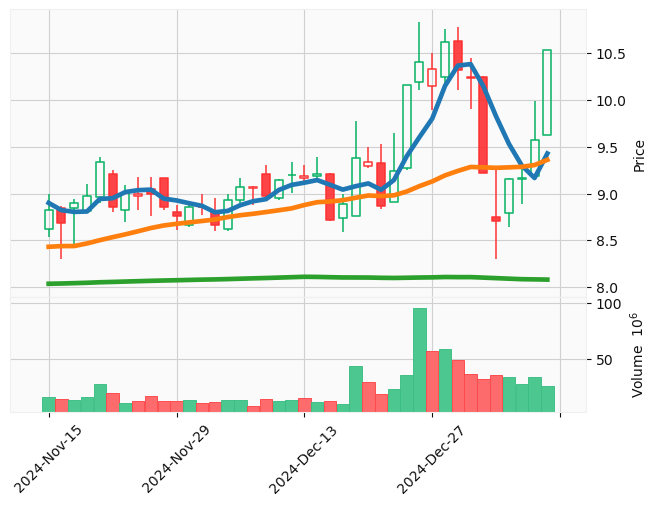

In [235]:
ma_add = Merge([MA(close,5),MA(close,30),MA(close,250)]).tail(40)
ma_add = mpf.make_addplot(ma_add)
mpf.plot(ticker_hist.tail(40),type='hollow_and_filled',style='yahoo',volume=True,addplot=ma_add)

## Sample plotting on KDJ indicator

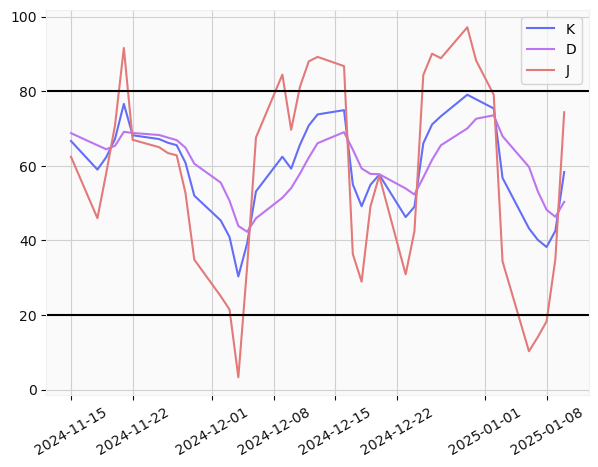

In [238]:
kdj = KDJ(ticker_hist).tail(40)
plt.figure(figsize=(7,5))
plt.plot(kdj['K'],color='#636EF7',label='K')
plt.plot(kdj['D'],color='#BD74F0',label='D')
plt.plot(kdj['J'],color='#E37979',label='J')
plt.legend(loc='best')
plt.axhline(y=80,color='black')
plt.axhline(y=20,color='black')
plt.xticks(rotation=30)
plt.show()

## Sample plotting on MACD indicator

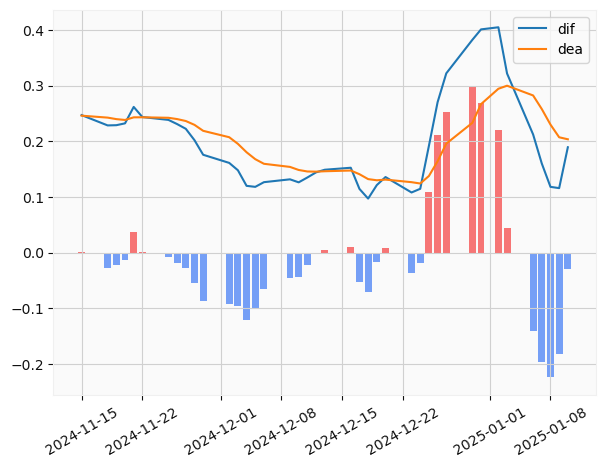

In [239]:
macd = MACD(ticker_hist).tail(40)
plt.figure(figsize=(7,5))
below = macd.macd[macd.macd<0]
above = macd.macd[macd.macd>=0]
plt.bar(below.index,below,color='#759FF6')
plt.bar(above.index,above,color='#F67575')
plt.plot(macd.dif,label='dif')
plt.plot(macd.dea,label='dea')
plt.legend(loc='best')
plt.xticks(rotation=30)
plt.show()

## Sample plotting on RSI indicator

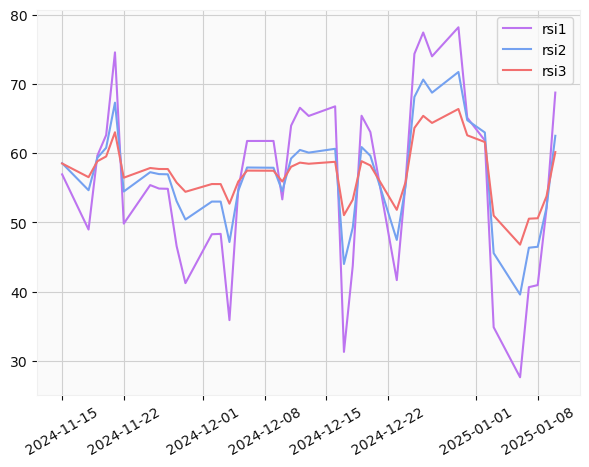

In [252]:
rsi = RSI(close).tail(40)
plt.figure(figsize=(7,5))
plt.plot(rsi.rsi1,color='#BD74F0',label='rsi1')
plt.plot(rsi.rsi2,color='#74A1F0',label='rsi2')
plt.plot(rsi.rsi3,color='#F26F6F',label='rsi3')
plt.xticks(rotation=30)
plt.legend(loc='best')
plt.show()